# <b>Decision Tree approach for the binary class classification problem</b>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os




from sklearn.preprocessing import Normalizer

In [5]:
#please use below code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

## Sentiment scores

In [8]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kira\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='what death is happening here.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1> Decision Tree </h1>

## 1.1 Loading Data

In [20]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
import pandas
data = pandas.read_csv('preprocessed_data.csv')
print(f"data.shape:{data.shape}")
data.head(3)

data.shape:(109248, 9)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


## Steps
1. calculate sentiment scores for the essay feature 
2. Split your data.
3. perform tfidf vectorization of text data.
4. perform tfidf w2v vectorization of text data.
5. perform encoding of categorical features.
6. perform encoding of numerical features
7. stack up all the features
8. stack up all the features (for stacking dense features you can use np.stack)
9. Perform hyperparameter tuning and plot either heatmap or 3d plot.
10. Find the best parameters and fit the model. Plot ROC-AUC curve(using predict proba method)
11. Plot confusion matrix based on best threshold value
12. Find all the false positive data points and plot wordcloud of essay text and pdf of teacher_number_of_previously_posted_projects.
13. Write your observations about the wordcloud and pdf.

In [24]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
print(f"X shape:{X.shape}\ny shape:{y.shape}")

X shape:(109248, 8)
y shape:(109248,)


## Data Split

In [311]:

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=0)

print(f"X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}")
print(f"X_train shape:{X_test.shape}\nY_train shape:{y_test.shape}")

X_train shape:(73196, 8)
Y_train shape:(73196,)
X_train shape:(36052, 8)
Y_train shape:(36052,)


### 'Essay' vectorization TFIDF

In [312]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10, max_features=5000)
text_tfidf = vectorizer_tfidf.fit(X_train["essay"])

X_train_essay_tfidf = text_tfidf.transform(X_train["essay"])
X_test_essay_tfidf = text_tfidf.transform(X_test["essay"])

print(f"X_train_essay_tfidf.shape:{X_train_essay_tfidf.shape},y_train.shape:{y_train.shape}")
print(f"X_test_essay_tfidf.shape:{X_test_essay_tfidf.shape},y_test.shape: {y_test.shape}")


X_train_essay_tfidf.shape:(73196, 5000),y_train.shape:(73196,)
X_test_essay_tfidf.shape:(36052, 5000),y_test.shape: (36052,)


### 'Essay' vectorization TFIDF-W2V

In [313]:

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["essay"]) 
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)
    

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(f"Train tfidf matrix shape:{np.array(tfidf_w2v_vectors_train).shape}")
print(f"Test tfidf matrix shape:{np.array(tfidf_w2v_vectors_test).shape}")

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [00:59<00:00, 605.67it/s]

Train tfidf matrix shape:(73196, 300)
Test tfidf matrix shape:(36052, 300)


### Encoding numerical, categorical features

In [314]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().
print('school_state')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)
print(f"X_train_state_ohe.shape:{X_train_state_ohe.shape},y_train.shape:{y_train.shape}")
print(f"X_test_state_ohe.shape:{X_test_state_ohe.shape},y_test.shape: {y_test.shape}")
print(vectorizer.get_feature_names())
vectorizer_state_ohe = vectorizer
print("="*100)


print('teacher_prefix')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)
print(f"X_train_teacher_ohe.shape:{X_train_teacher_ohe.shape},y_train.shape:{y_train.shape}")
print(f"X_test_teacher_ohe.shape:{X_test_teacher_ohe.shape},y_test.shape: {y_test.shape}")
print(vectorizer.get_feature_names())
vectorizer_teacher_ohe = vectorizer
print("="*100)


print('project_grade_category')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) 
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
print("After vectorizations")
print(f"X_train_grade_ohe.shape:{X_train_grade_ohe.shape},y_train.shape:{y_train.shape}")
print(f"X_test_grade_ohe.shape:{X_test_grade_ohe.shape},y_test.shape: {y_test.shape}")
print(vectorizer.get_feature_names())
vectorizer_grade_ohe = vectorizer
print("="*100)


print('clean_subcategories')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
X_train_sub_cat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_cat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)
print(f"X_train_sub_cat_ohe.shape:{X_train_sub_cat_ohe.shape},y_train.shape:{y_train.shape}")
print(f"X_test_sub_cat_ohe.shape:{X_test_sub_cat_ohe.shape},y_test.shape: {y_test.shape}")
print(vectorizer.get_feature_names())
vectorizer_sub_cat_ohe = vectorizer
print("="*100)



print('clean_categories')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)
print(f"X_train_cat_ohe.shape:{X_train_cat_ohe.shape},y_train.shape:{y_train.shape}")
print(f"X_test_cat_ohe.shape:{X_test_cat_ohe.shape},y_test.shape: {y_test.shape}")
print(vectorizer.get_feature_names())
vectorizer_cat_ohe = vectorizer
print("="*100)





print('price')
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
normalizer_ = Normalizer()
X_test_price_norm = normalizer_.fit_transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)
print(f"X_train_price_norm.shape:{X_train_price_norm.shape},y_train.shape:{y_train.shape}")
print(f"X_test_price_norm.shape:{X_test_price_norm.shape},y_test.shape: {y_test.shape}")
print("="*100)




print('teacher_number_of_previously_posted_projects')
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_pre_nos_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
normalizer_ = Normalizer()
X_test_pre_nos_norm = normalizer_.fit_transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
print(f"X_train_pre_nos_norm.shape:{X_train_pre_nos_norm.shape},y_train.shape:{y_train.shape}")
print(f"X_test_pre_nos_norm.shape:{X_test_pre_nos_norm.shape},y_test.shape: {y_test.shape}")
print("="*100)




school_state
X_train_state_ohe.shape:(73196, 51),y_train.shape:(73196,)
X_test_state_ohe.shape:(36052, 51),y_test.shape: (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
teacher_prefix
X_train_teacher_ohe.shape:(73196, 5),y_train.shape:(73196,)
X_test_teacher_ohe.shape:(36052, 5),y_test.shape: (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
project_grade_category
After vectorizations
X_train_grade_ohe.shape:(73196, 4),y_train.shape:(73196,)
X_test_grade_ohe.shape:(36052, 4),y_test.shape: (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
clean_subcategories
X_train_sub_cat_ohe.shape:(73196, 30),y_train.shape:(73196,)
X_test_sub_cat_ohe.shape:(36052, 30),y_test.shape: (36052,)
['appliedsciences', 'care_hunge

### Getting Sentiment feature from essay

In [318]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

N = X_train.shape[0]
Nt = X_test.shape[0]
sentiment_scores_essay = np.ones(N)
sample_sentence_1='I am happy.'

sentiment_scores_essay_list_train = []
for sentance in tqdm(X_train['essay'].values):
    sid.polarity_scores(sentance)
    sentiment_scores_essay_list_train.append(list(sid.polarity_scores(sentance).values()))
    
sentiment_scores_essay_list_test = []
for sentance in tqdm(X_test['essay'].values):
    sentiment_scores_essay_list_test.append(list(sid.polarity_scores(sentance).values()))

# #neg, neu, pos, compound    
X_train_sentiment_score_essay = np.array(sentiment_scores_essay_list_train).reshape((N,4))
X_test_sentiment_score_essay = np.array(sentiment_scores_essay_list_test).reshape((Nt,4))


print(f"X_train_sentiment_score_essay.shape:{X_train_sentiment_score_essay.shape},y_train.shape: {y_test.shape}")
print(f"X_test_sentiment_score_essay.shape:{X_test_sentiment_score_essay.shape},y_test.shape: {y_test.shape}")

X_train_sentiment_score_essay.shape:(73196, 4),y_train.shape: (36052,)
X_test_sentiment_score_essay.shape:(36052, 4),y_test.shape: (36052,)


## SET-1
##### Side by side concatenation of feature vectors (TFIDF)

In [376]:
 
from scipy.sparse import hstack
X_train_vec = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,\
                X_train_pre_nos_norm,X_train_sub_cat_ohe, X_train_cat_ohe, X_train_sentiment_score_essay)).tocsr()


X_test_vec = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,\
                X_test_pre_nos_norm,X_test_sub_cat_ohe, X_test_cat_ohe, X_test_sentiment_score_essay)).tocsr()

print("Final Data matrix")
print(f"X_train_vec.shape:{X_train_vec.shape},y_train.shape:{y_train.shape}")
print(f"X_test_vec.shape:{X_test_vec.shape},y_test.shape: {y_test.shape}")
print("="*100)


Final Data matrix
X_train_vec.shape:(73196, 5105),y_train.shape:(73196,)
X_test_vec.shape:(36052, 5105),y_test.shape: (36052,)


In [321]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def find_hyperparameter(X_train_vec, y_train):
    '''
    This functions executes GRID search on the input data and
    returns a 'results'(clf.cv_results_) dataframe containing all results of the sklearn Grid search
    '''
    print("Begins..find_hyperparameter")
    dt = DecisionTreeClassifier()
    tree_para = {
                  "max_depth":[1, 3, 10, 30],
                  "min_samples_split": [5, 10, 100, 500]
                }
    clf = GridSearchCV(dt, tree_para, cv=3, scoring='roc_auc', return_train_score=True)
    clf.fit(X_train_vec, y_train)

    results = pd.DataFrame.from_dict(clf.cv_results_)
    print("Done")
    return results


def test_cv_auc_scores(results):
    '''
    This function takes 'results'(clf.cv_results_) dataframe generated by sklearn  Grid search
    and returns two dataframe 'df_train', 'df_test'
    Columns of the dataframe represents 'min_samples_split' and rows represents 'max_depth' and
    corresp
    onding value represents AUC scores
    '''
    print("Begins..test_cv_auc_scores")
    
    #Getting all max_depths with which model trained.
    max_depth_x = [i['max_depth'] for i in results['params'].values ]
    
    #Getting all min_samples_split with which model trained.
    min_samples_split_y = [i['min_samples_split'] for i in results['params'].values ]
    
    #Getting mean train AUC score in 'z1'
    z1 = results['mean_train_score'].values 
    
    #Getting mean test AUC score in 'z2'
    z2 = results['mean_test_score'].values
    
    
    #Creating dictionaries 
    #key->(a,b) where a:max_depth b:min_samples_split
    #value-> AUC score with the pair (a,b)
    auc_scores_train_dict, auc_scores_test_dict = {}, {}
    for i, j, k in zip(max_depth_x, min_samples_split_y, z1):
        auc_scores_train_dict[(i,j)] = k
    for i, j, k in zip(max_depth_x, min_samples_split_y, z2):
        auc_scores_test_dict[(i,j)] = k


    df_list_train, df_list_test = [], []
    
    #Creating grid, each value represents AUC scores of the pair (max_depth, min_samples_split) and the 
    #grid is nothing but a list of lists.
    for d in [1, 3, 10, 30]:
        df_list_temp_train, df_list_temp_test  = [], []
        for splits in [5, 10, 100, 500]:
            df_list_temp_train.append(auc_scores_train_dict[(d,splits)])
            df_list_temp_test.append(auc_scores_test_dict[(d,splits)])
        df_list_train.append(df_list_temp_train)
        df_list_test.append(df_list_temp_test)
        
    
    #List of lists GRID now getting converted into dataframes
    df_train = pd.DataFrame(df_list_train, index = [1, 3, 10, 30], columns=[5, 10, 100, 500])
    df_cv = pd.DataFrame(df_list_test, index = [1, 3, 10, 30], columns=[5, 10, 100, 500])
    print("done!")
    return df_train, df_cv


## Hyperparameter tuning

In [322]:
results = find_hyperparameter(X_train_vec, y_train)
df_train, df_cv = test_cv_auc_scores(results)


Begins..find_hyperparameter
Done
Begins..test_cv_auc_scores
done!


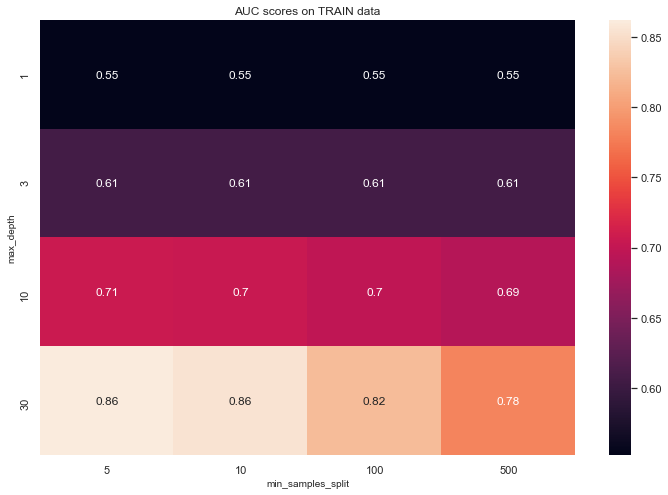

In [323]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
ax = sns.heatmap(df_train, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on TRAIN data', fontdict={'fontweight': 120})
print("")

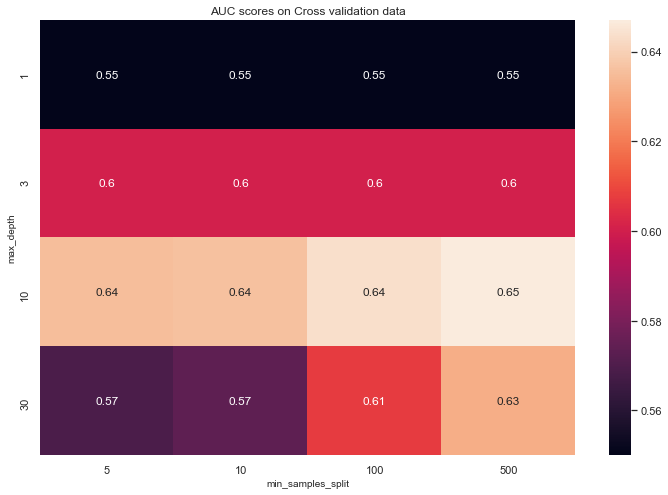

In [324]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
sns.heatmap(df_cv, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on Cross validation data', fontdict={'fontweight': 120})
print("")

In [325]:
# https://plot.ly/python/3d-axes/
z1 = results['mean_train_score'].values 
z2 = results['mean_test_score'].values
trace1 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z1, name = 'train')
trace2 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_Depth'),
        yaxis = dict(title='min_samples_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


## BEST HYPERPARAMETERS (TFIDF):
         * max_depth:10
         * min_samples_split: 500

## Training Decision tree 

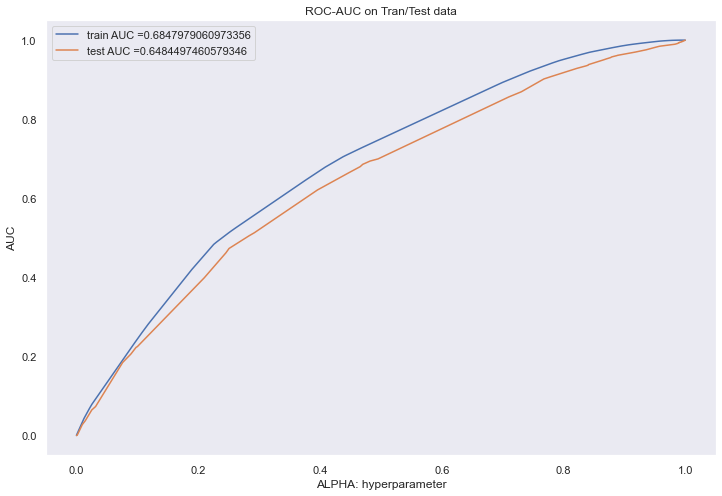

In [327]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


DT_1 = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
DT_1.fit(X_train_vec, y_train) 

y_train_pred = DT_1.predict_proba(X_train_vec)[:,1]
y_test_pred = DT_1.predict_proba(X_test_vec)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("ALPHA: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC-AUC on Tran/Test data")
plt.grid()
plt.show()

#### Train confusion matrix

the maximum value of tpr*(1-fpr) 0.4028278863800172 for threshold 0.855


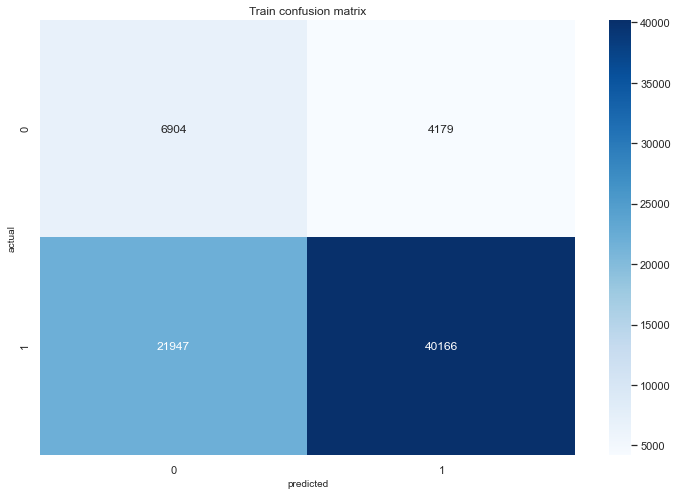

In [328]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr) 
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Train confusion matrix")
plt.show()

####  Test confusion matrix

the maximum value of tpr*(1-fpr) 0.375205409573182 for threshold 0.855


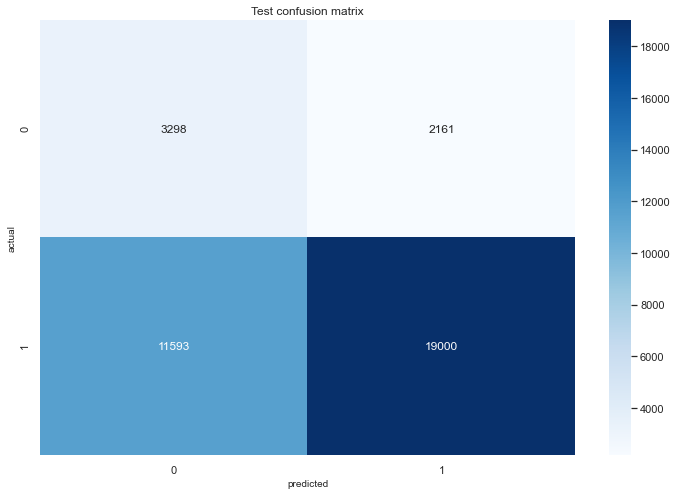

In [329]:
best_t = find_best_threshold(tr_thresholds, test_fpr, test_tpr) 
cm_tr = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Test confusion matrix")
plt.show()

### Getting False positive dataframe

In [330]:
zipped = zip(X_train['essay'].values,\
             X_train['price'].values,\
             X_train['teacher_number_of_previously_posted_projects'].values,\
             y_test,  predict_with_best_t(y_test_pred, best_t))

columns = ['essay','price','teacher_number_of_previously_posted_projects','y','y_hat']

df_ = pd.DataFrame(zipped, columns=columns)
df_FP = df_[(df_['y'] == 0) & (df_['y_hat'] == 1)] 
print(f"False positive dataset shape:{df_FP.shape}")

False positive dataset shape:(2161, 5)


### Word cloud on FP 'essay'

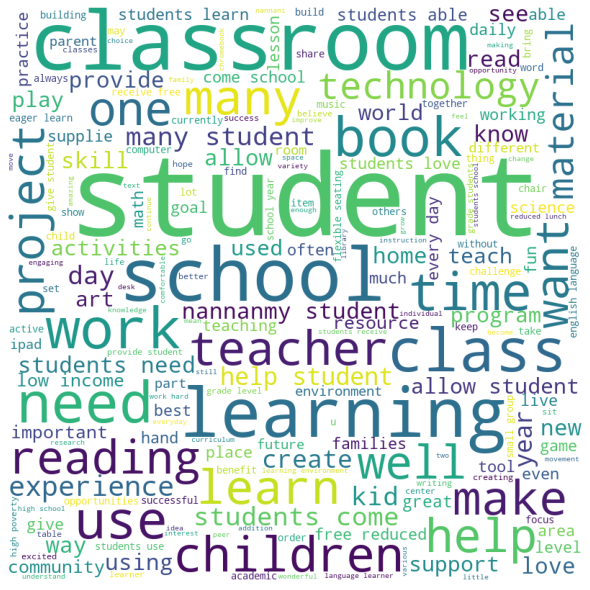

In [331]:
strings = ''
for i in df_FP['essay'].values:
    strings += i
    
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(strings)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Box plot on FP 'price'

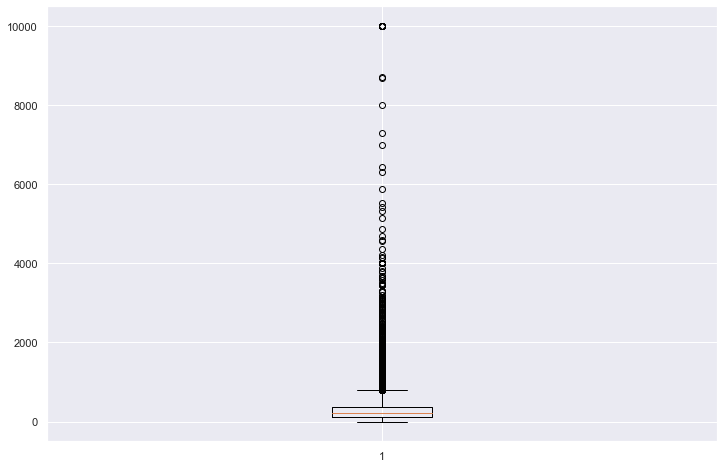

In [332]:
plt.boxplot(df_['price'])
plt.show()

### PDF on FP 'teacher_number_of_previously_posted_projects'

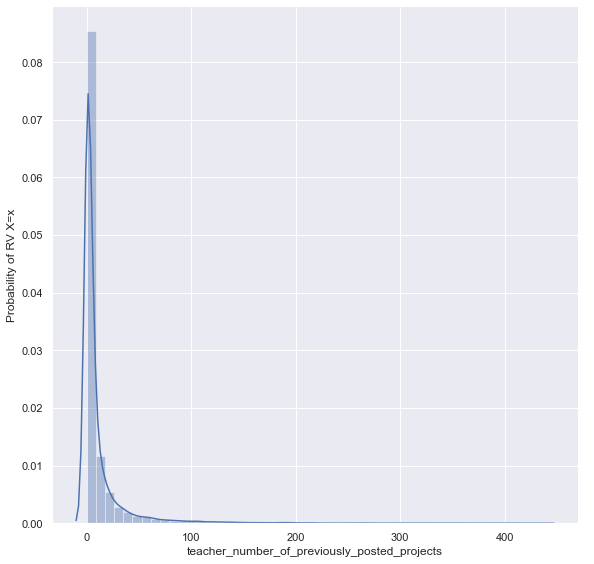

In [333]:
sns.FacetGrid(df_,size=8)\
   .map(sns.distplot, 'teacher_number_of_previously_posted_projects')\
   .add_legend()
plt.ylabel('Probability of RV X=x')
plt.show()

# SET-2

##### Side by side concatenation of feature vectors (TFIDF-W2V)

In [353]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
from scipy.sparse import hstack
X_train_vec = hstack((tfidf_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,\
                X_train_pre_nos_norm,X_train_sub_cat_ohe, X_train_cat_ohe,X_train_sentiment_score_essay)).tocsr()


X_test_vec = hstack((tfidf_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,\
                X_test_pre_nos_norm,X_test_sub_cat_ohe, X_test_cat_ohe,X_test_sentiment_score_essay)).tocsr()

print("Final Data matrix")
print(f"X_train_vec.shape:{X_train_vec.shape},y_train.shape:{y_train.shape}")
print(f"X_test_vec.shape:{X_test_vec.shape},y_test.shape: {y_test.shape}")
print("="*100)

Final Data matrix
X_train_vec.shape:(73196, 405),y_train.shape:(73196,)
X_test_vec.shape:(36052, 405),y_test.shape: (36052,)


In [354]:
results_ = find_hyperparameter(X_train_vec, y_train)
df_train, df_cv = test_cv_auc_scores(results_)


Begins..find_hyperparameter
Done
Begins..test_cv_auc_scores
done!


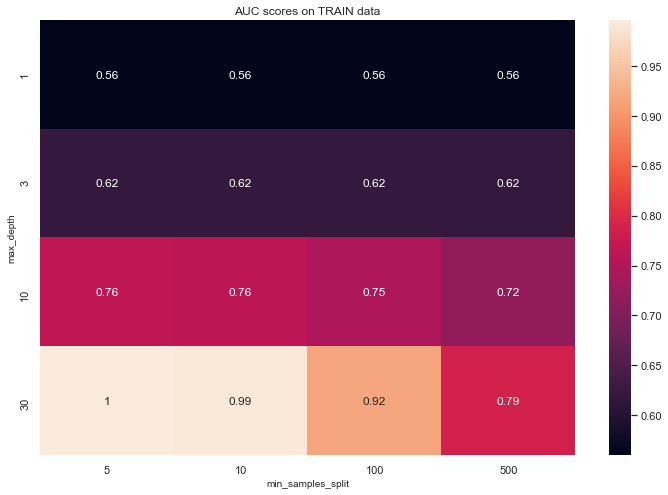

In [356]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
ax = sns.heatmap(df_train, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on TRAIN data', fontdict={'fontweight': 120})
print("")

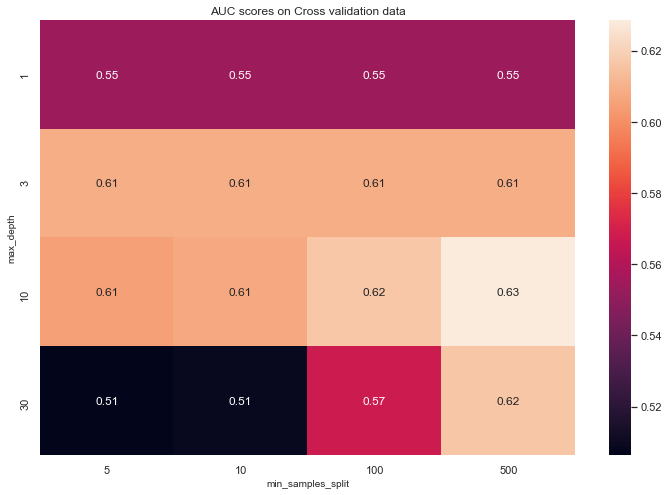

In [360]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
ax = sns.heatmap(df_cv, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on Cross validation data', fontdict={'fontweight': 120})
print("")

In [361]:
z1 = results_['mean_train_score'].values 
z2 = results_['mean_test_score'].values 
trace1 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z1, name = 'train')
trace2 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_Depth'),
        yaxis = dict(title='min_samples_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


## BEST HYPERPARAMETERS (TFIDF-W2V):
         * max_depth:10
         * min_samples_split: 500

## Training Decision tree

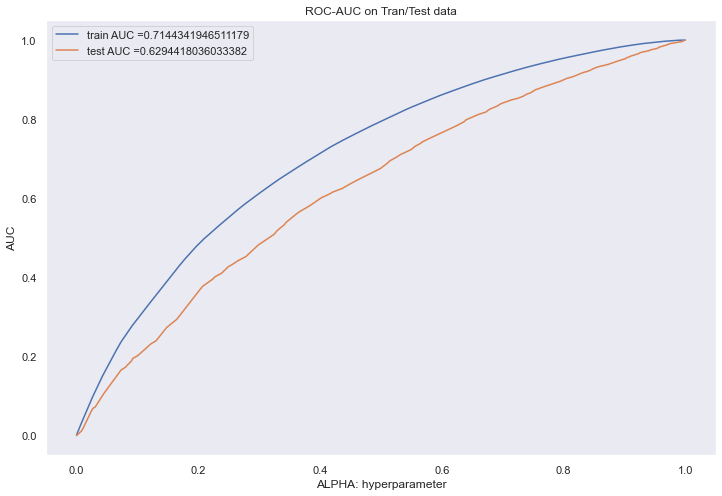

In [359]:

from sklearn.metrics import roc_curve, auc


DT_2 = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
DT_2.fit(X_train_vec, y_train) 

y_train_pred = DT_2.predict_proba(X_train_vec)[:,1]
y_test_pred = DT_2.predict_proba(X_test_vec)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("ALPHA: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC-AUC on Tran/Test data")
plt.grid()
plt.show()

#### Train confusion matrix

the maximum value of tpr*(1-fpr) 0.4325610127562488 for threshold 0.849


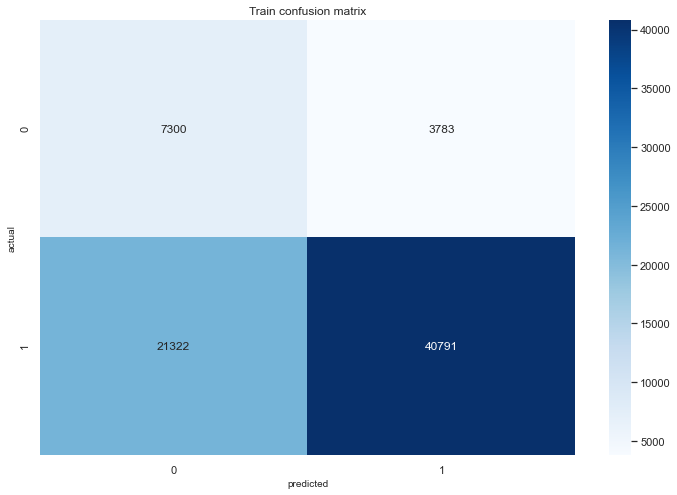

In [362]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr) 
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Train confusion matrix")
plt.show()

#### Test confusion matrix

the maximum value of tpr*(1-fpr) 0.35950069621854064 for threshold 0.858


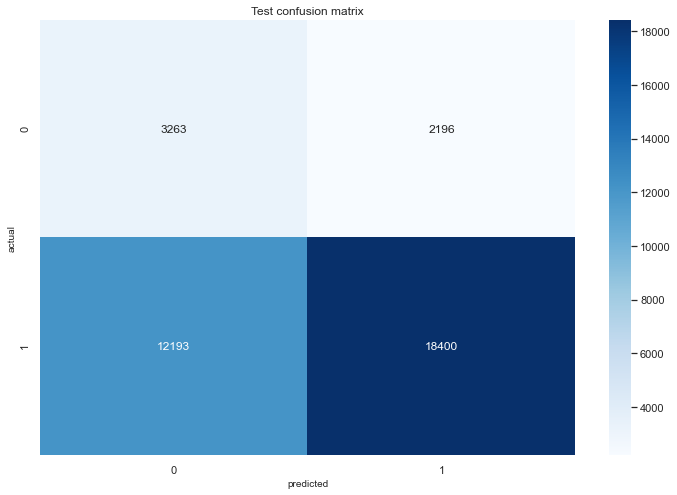

In [363]:
best_t = find_best_threshold(tr_thresholds, test_fpr, test_tpr) 
cm_tr = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Test confusion matrix")
plt.show()

#### Getting FP dataframe

In [364]:
zipped = zip(X_train['essay'].values,\
             X_train['price'].values,\
             X_train['teacher_number_of_previously_posted_projects'].values,\
             y_test,  predict_with_best_t(y_test_pred, best_t))

columns = ['essay','price','teacher_number_of_previously_posted_projects','y','y_hat']

df_ = pd.DataFrame(zipped, columns=columns)
df_FP = df_[(df_['y'] == 0) & (df_['y_hat'] == 1)] 
print(f"False positive dataset shape:{df_FP.shape}")

False positive dataset shape:(2196, 5)


#### Word cloud on FP 'essay'

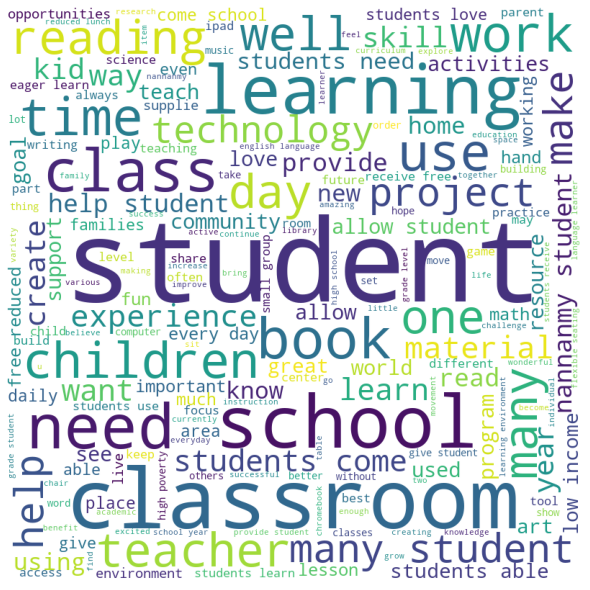

In [365]:
strings = ''
for i in df_FP['essay'].values:
    strings += i
    
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(strings)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

#### Box plot on FP 'price'

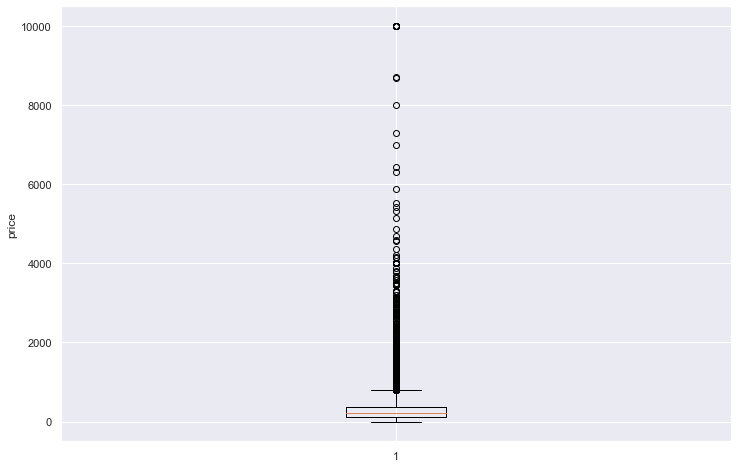

In [413]:
plt.boxplot(df_['price'])
plt.ylabel('price')
plt.show()

#### PDF on FP 'teacher_number_of_previously_posted_projects'

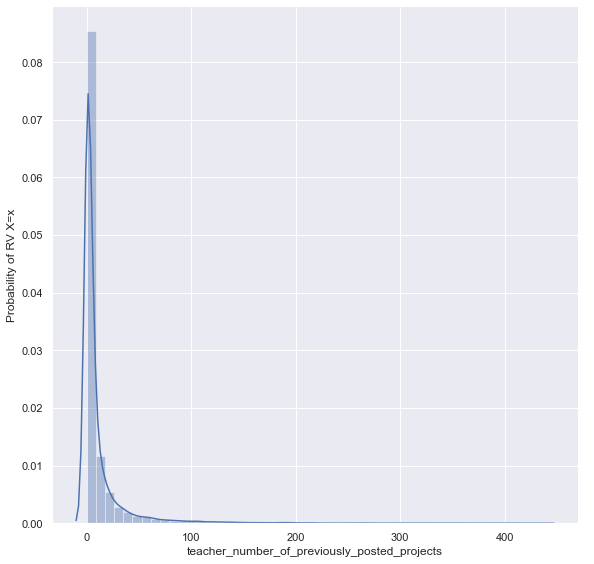

In [367]:
sns.FacetGrid(df_,size=8)\
   .map(sns.distplot, 'teacher_number_of_previously_posted_projects')\
   .add_legend()
plt.ylabel('Probability of RV X=x')
plt.show()

### Getting feature names

In [397]:
all_feature_names = vectorizer_tfidf.get_feature_names() + \
vectorizer_state_ohe.get_feature_names() + \
vectorizer_teacher_ohe.get_feature_names() + \
vectorizer_grade_ohe.get_feature_names() + \
['price'] + ['teacher_number_of_previously_posted_projects'] + \
vectorizer_sub_cat_ohe.get_feature_names() + \
vectorizer_cat_ohe.get_feature_names()+ ['neg', 'neu', 'pos', 'compound']    

In [398]:
all_feature_names = np.array(all_feature_names)

### All non zero features importance

In [399]:
all_feature_names[np.where(DT_1.feature_importances_ != 0)[0]]

array(['32', '36', 'academically', 'accommodate', 'achieving', 'added',
       'aged', 'alternative', 'beauty', 'books', 'but', 'chromebooks',
       'completing', 'creativity', 'crime', 'daily', 'difference', 'dig',
       'donors', 'educated', 'education', 'environments', 'expand',
       'explore', 'expressive', 'face', 'faced', 'feed', 'financial',
       'happen', 'harder', 'heads', 'higher', 'honored', 'idea',
       'imaginations', 'includes', 'inspire', 'internet', 'ipad', 'job',
       'knowledge', 'leader', 'level', 'live', 'local', 'located',
       'maker', 'materials', 'mind', 'mostly', 'nannan', 'need', 'offer',
       'ongoing', 'order', 'pairs', 'participate', 'pay', 'pk',
       'practices', 'preschool', 'problem', 'published', 'rather',
       'reinforce', 'rent', 'retain', 'rug', 'seat', 'serves', 'skills',
       'soccer', 'soft', 'spanish', 'special', 'sportsmanship', 'stools',
       'subject', 'supplies', 'these', 'use', 'visuals', 'wobble',
       'writing', 'ye

 #### Getting new train/test Vector using Non zero Features

In [400]:
X_train_vec_new = X_train_vec[:,np.where(DT_1.feature_importances_ != 0)[0]]
X_test_vec_new = X_test_vec[:,np.where(DT_1.feature_importances_ != 0)[0]]
print(f"X_train_vec_new.shape:{X_train_vec_new.shape},y_train.shape: {y_train.shape}")
print(f"X_test_vec_new.shape:{X_test_vec_new.shape},y_test.shape: {y_test.shape}")

X_train_vec_new.shape:(73196, 91),y_train.shape: (73196,)
X_test_vec_new.shape:(36052, 91),y_test.shape: (36052,)


### Hyperparameter tuning on new train data

In [401]:
results_ = find_hyperparameter(X_train_vec_new, y_train)
df_train, df_cv = test_cv_auc_scores(results_)


Begins..find_hyperparameter
Done
Begins..test_cv_auc_scores
done!


### AUC on new Train 

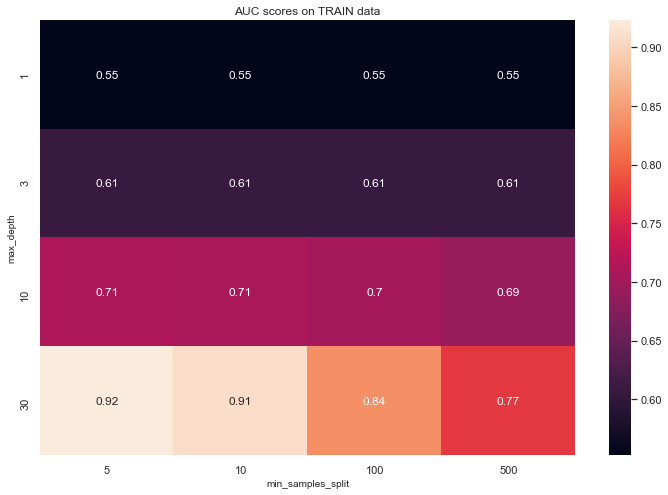

In [402]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
ax = sns.heatmap(df_train, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on TRAIN data', fontdict={'fontweight': 120})
print("")

### AUC on new CV

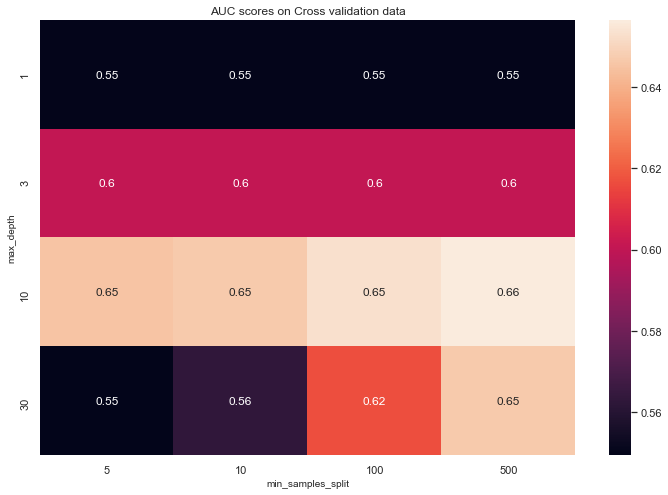

In [403]:
ax = plt.axes()
sns.set(rc = {'figure.figsize':(12,8)}) 
ax = sns.heatmap(df_cv, annot=True, ax=ax)
ax.set_xlabel('min_samples_split', fontsize=10)
ax.set_ylabel('max_depth', fontsize=10)
ax.set_title('AUC scores on Cross validation data', fontdict={'fontweight': 120})
print("")

### 3D plot

In [404]:
z1 = results_['mean_train_score'].values 
z2 = results_['mean_test_score'].values 
trace1 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z1, name = 'train')
trace2 = go.Scatter3d(x=max_depth_x,y=min_samples_split_y,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_Depth'),
        yaxis = dict(title='min_samples_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')


## BEST HYPERPARAMETERS (TFIDF-W2V):
         * max_depth:10
         * min_samples_split: 500

### Training Decision tree

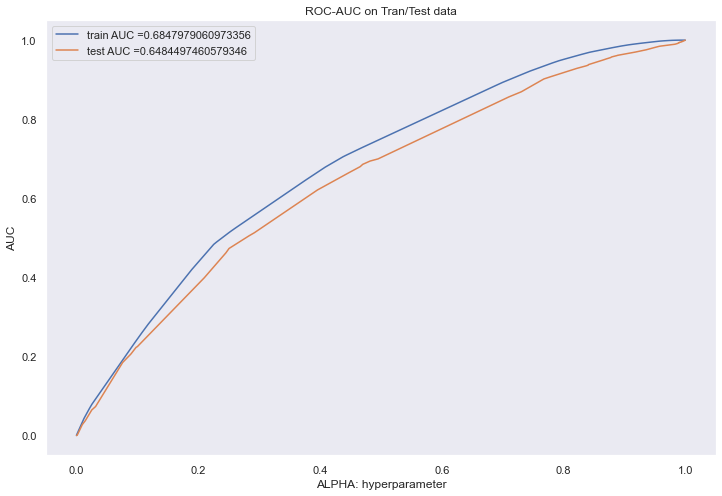

In [405]:

from sklearn.metrics import roc_curve, auc


DT = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
DT.fit(X_train_vec_new, y_train) 

y_train_pred = DT.predict_proba(X_train_vec_new)[:,1]
y_test_pred = DT.predict_proba(X_test_vec_new)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("ALPHA: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC-AUC on Tran/Test data")
plt.grid()
plt.show()

### Confusion matrix on New Train

the maximum value of tpr*(1-fpr) 0.4028278863800172 for threshold 0.855


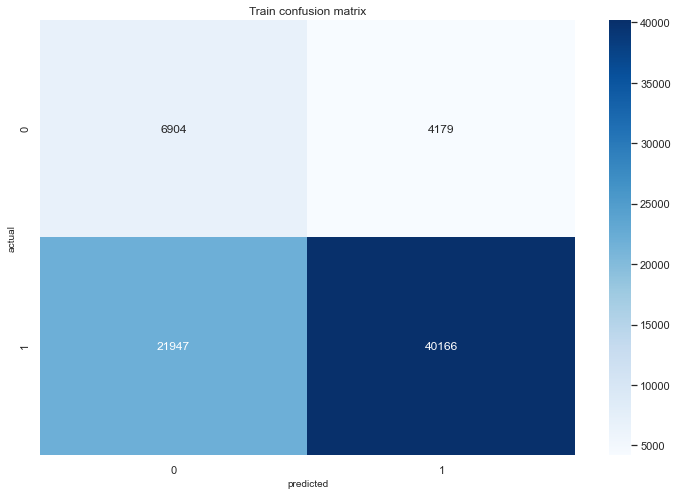

In [406]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr) 
cm_tr = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Train confusion matrix")
plt.show()

### Confusion matrix on New Test

the maximum value of tpr*(1-fpr) 0.375205409573182 for threshold 0.855


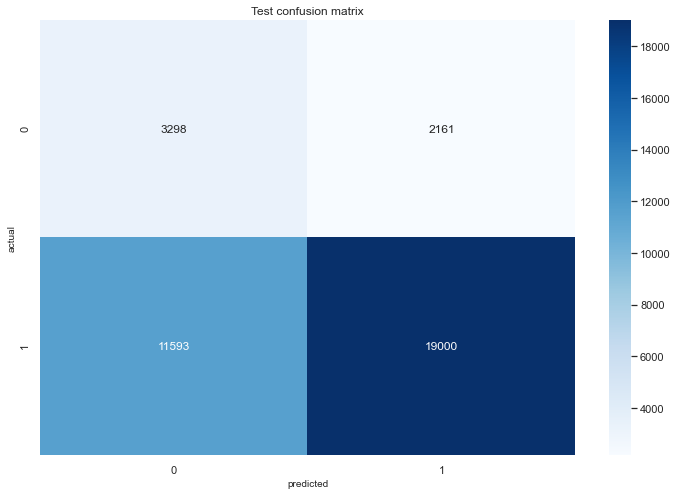

In [407]:
best_t = find_best_threshold(tr_thresholds, test_fpr, test_tpr) 
cm_tr = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = plt.axes()
sns.heatmap(cm_tr, annot=True,fmt="d",cmap='Blues')
ax.set_xlabel('predicted', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
ax.set_title("Test confusion matrix")
plt.show()

### Getting FP dataframe

In [408]:
zipped = zip(X_train['essay'].values,\
             X_train['price'].values,\
             X_train['teacher_number_of_previously_posted_projects'].values,\
             y_test,  predict_with_best_t(y_test_pred, best_t))

columns = ['essay','price','teacher_number_of_previously_posted_projects','y','y_hat']

df_ = pd.DataFrame(zipped, columns=columns)
df_FP = df_[(df_['y'] == 0) & (df_['y_hat'] == 1)] 
print(f"False positive dataset shape:{df_FP.shape}")

False positive dataset shape:(2161, 5)


### Word cloud

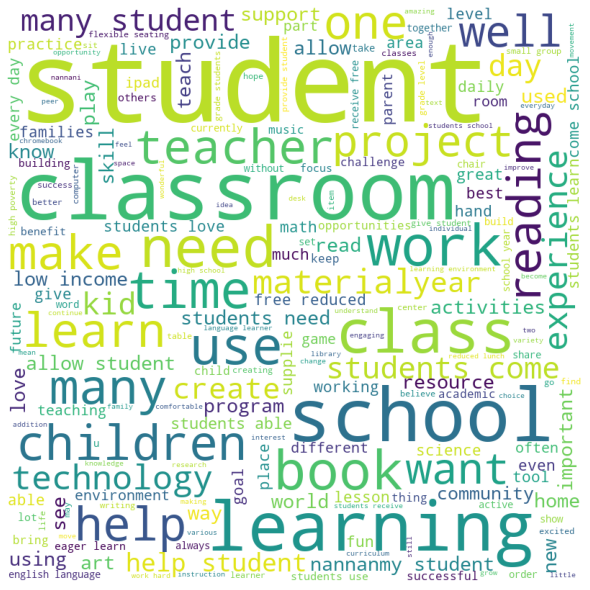

In [409]:
strings = ''
for i in df_FP['essay'].values:
    strings += i
    
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(strings)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Box plot 

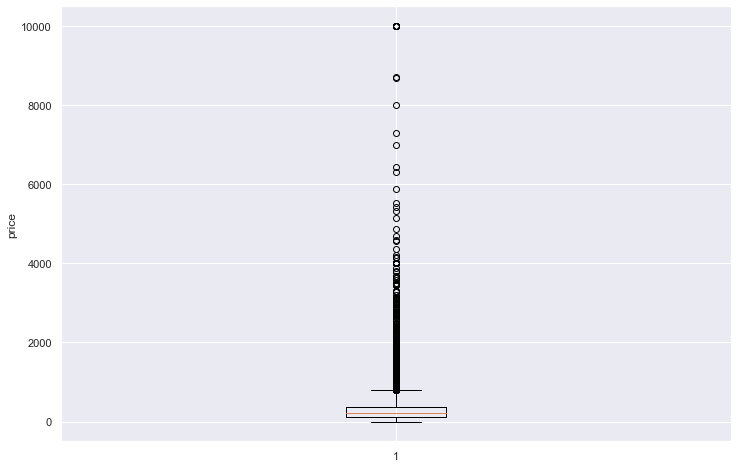

In [412]:
plt.boxplot(df_['price'])
plt.ylabel('price')
plt.show()

### PDF

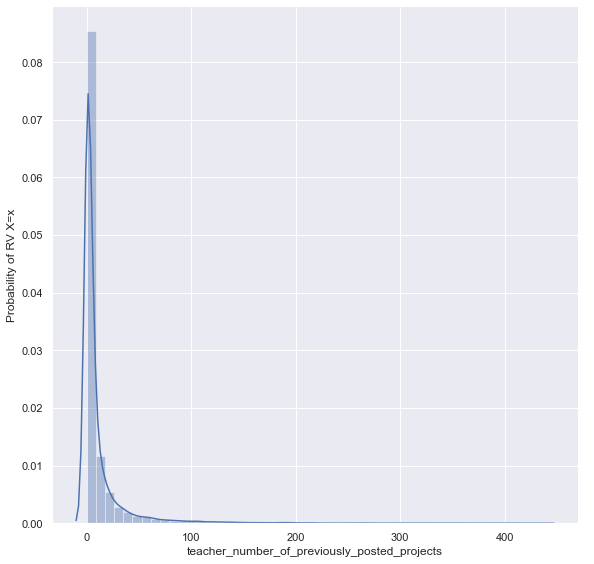

In [411]:
sns.FacetGrid(df_,size=8)\
   .map(sns.distplot, 'teacher_number_of_previously_posted_projects')\
   .add_legend()
plt.ylabel('Probability of RV X=x')
plt.show()

# Summary

In [416]:
from prettytable import PrettyTable 

myTable = PrettyTable(["Vectorizer", "Model", "Hyperparameter","Max_depth","min_samples_split", "AUC(train)", "AUC(test)"])
  

myTable.add_row(["TFIDF", "Brute", "8","10","500", "0.68", "0.648"])
myTable.add_row(["TFIDF W2V", "Brute", "8","10","500", "0.710", "0.62"])
print(myTable)

+------------+-------+----------------+-----------+-------------------+------------+-----------+
| Vectorizer | Model | Hyperparameter | Max_depth | min_samples_split | AUC(train) | AUC(test) |
+------------+-------+----------------+-----------+-------------------+------------+-----------+
|   TFIDF    | Brute |       8        |     10    |        500        |    0.68    |   0.648   |
| TFIDF W2V  | Brute |       8        |     10    |        500        |   0.710    |    0.62   |
+------------+-------+----------------+-----------+-------------------+------------+-----------+
